# Layer normalization

Denote by $ x \in \mathbb{R}^H$ the vector of intralayer features (channels).

1. Compute statistics (mean and variance):
  $$
  \mu = \frac{1}{H}\sum_{i=1}^{H} x_{i}, 
  \qquad
  \sigma^2 = \frac{1}{H}\sum_{i=1}^{H} (x_{i} - \mu)^2.
  $$
  
  
  2. Normalize and apply learnable affine transformation with parameters (scale $\gamma$ and shift $\beta$):
  $$
  \hat{x}_{i} = \gamma \cdot \frac{x_{i} - \mu}{\sqrt{\sigma^2 + \varepsilon}} + \beta.
  $$

In [1]:
import torch
import torch.nn as nn

## Hand-Rolled 

In [2]:
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super().__init__()
        self.normalized_shape = (normalized_shape,)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(self.normalized_shape))
            self.bias = nn.Parameter(torch.zeros(self.normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x):
        # Compute mean and variance over last N dims
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        if self.elementwise_affine:
            x_norm = x_norm * self.weight + self.bias
        return x_norm

In [3]:
class MLPLN(nn.Module):
    def __init__(self, ln_net_cls, input_dim, hidden_dim, output_dim, pos=False):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dim:
            if pos:
                layers.append(nn.Linear(in_dim, h_dim,bias=False)) # bias learned by LinearLayer
                if in_dim > 1:
                    layers.append(ln_net_cls(h_dim)) 
            else:
                # Only pass elementwise_affine if using nn.LayerNorm
                if in_dim > 1:
                    layers.append(ln_net_cls(in_dim, elementwise_affine=False))
                layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
x = torch.randn(5, 28, 28)
torch.manual_seed(1)
out_refs = []
for i in range(10):
    net = MLPLN(nn.LayerNorm,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out= net(x)
    out_norm=out.norm().item()
    print(f'{i} - {out_norm = }')
    out_refs.append(out)


0 - out_norm = 12.892267227172852
1 - out_norm = 5.176924228668213
2 - out_norm = 5.181304931640625
3 - out_norm = 5.130053520202637
4 - out_norm = 5.078497409820557
5 - out_norm = 5.344673156738281
6 - out_norm = 5.6361918449401855
7 - out_norm = 5.721855163574219
8 - out_norm = 5.022321701049805
9 - out_norm = 5.447553634643555


In [5]:
torch.manual_seed(1)
for i in range(10):
    net = MLPLN(MyLayerNorm,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out = net(x)
    out_norm = out.norm().item()
    print(f'{i} - {out_norm = } - allclose: {torch.allclose(out_refs[i], out, atol=1e-5, rtol=0.0)}')

0 - out_norm = 12.892267227172852 - allclose: True
1 - out_norm = 5.176924228668213 - allclose: True
2 - out_norm = 5.181304454803467 - allclose: True
3 - out_norm = 5.1300530433654785 - allclose: True
4 - out_norm = 5.078496932983398 - allclose: True
5 - out_norm = 5.344673156738281 - allclose: True
6 - out_norm = 5.636191368103027 - allclose: True
7 - out_norm = 5.721855163574219 - allclose: True
8 - out_norm = 5.0223212242126465 - allclose: True
9 - out_norm = 5.447555065155029 - allclose: True


# Train 

In [6]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

### Generate data

In [7]:
f = lambda x: 1+2*x**2

N = 32
xs = (4*torch.rand(N)-2)[:,None]
ys = f(xs) + 0.5*torch.randn(N,1)
x_eval = torch.linspace(-2,2,100)

dataset = TensorDataset(xs, ys)

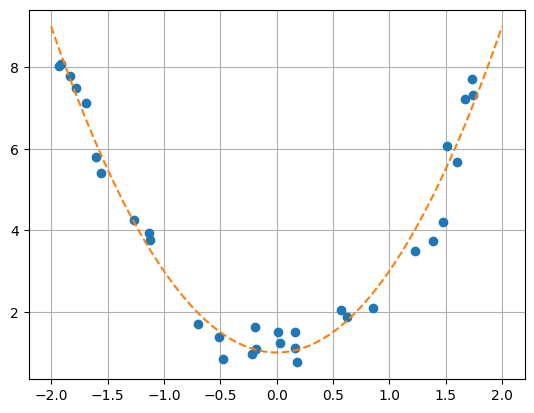

In [8]:
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o')
plt.plot(x_eval.detach().numpy(), f(x_eval).detach().numpy(), '--')
plt.grid()
plt.show()

In [9]:
lr = 0.001
momentum = 0.9
batch_size = N//4
hidden_dim = [64,64]
loss_fn = nn.MSELoss()  
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Torch

In [10]:
torch.manual_seed(1)

torchmodel = MLPLN(nn.LayerNorm,
                   input_dim=1, 
                   hidden_dim=hidden_dim, 
                   output_dim=1)
opt = torch.optim.SGD(torchmodel.parameters(), lr=lr, momentum=momentum)

torchmodel.train()
torch_losses = []
for epoch in range(100):
    for x, y in data_loader:
        preds = torchmodel(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        torch_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 24.06661033630371
Epoch 10, Loss: 1.3541854619979858
Epoch 20, Loss: 0.3984967768192291
Epoch 30, Loss: 0.33848392963409424
Epoch 40, Loss: 0.22660160064697266
Epoch 50, Loss: 0.2613476514816284
Epoch 60, Loss: 0.321408748626709
Epoch 70, Loss: 0.19286927580833435
Epoch 80, Loss: 0.2784160375595093
Epoch 90, Loss: 0.11067380011081696


### hand-rolled

In [11]:
torch.manual_seed(1)
mymodel = MLPLN(MyLayerNorm,input_dim=1, hidden_dim=hidden_dim, output_dim=1)
opt = torch.optim.SGD(mymodel.parameters(), lr=lr, momentum=momentum)
mymodel.train()
my_losses = []

for epoch in range(100):
    for x, y in data_loader:
        preds = mymodel(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        my_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        

Epoch 0, Loss: 24.06661033630371
Epoch 10, Loss: 1.3541849851608276
Epoch 20, Loss: 0.39849692583084106
Epoch 30, Loss: 0.3384839594364166
Epoch 40, Loss: 0.22660145163536072
Epoch 50, Loss: 0.26134783029556274
Epoch 60, Loss: 0.32140880823135376
Epoch 70, Loss: 0.19286927580833435
Epoch 80, Loss: 0.27841615676879883
Epoch 90, Loss: 0.11067362874746323


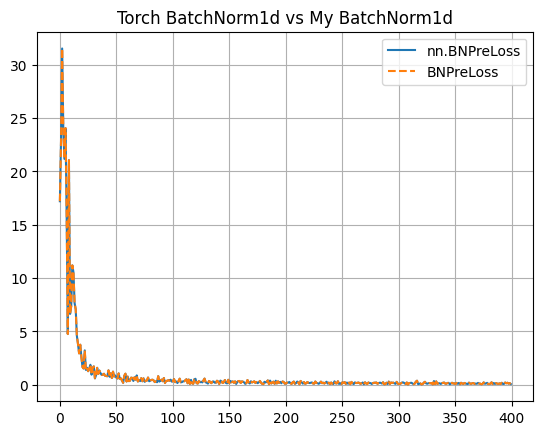

In [12]:
plt.plot(torch_losses,linestyle="-",label="nn.BNPreLoss")
plt.plot(my_losses,linestyle="--",label="BNPreLoss")
plt.title(f"Torch BatchNorm1d vs My BatchNorm1d")
plt.grid(True)
plt.legend()
plt.show()

# Evaluation

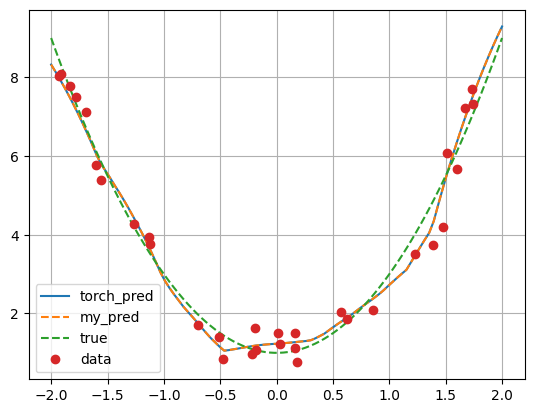

In [13]:
torchmodel.eval()
mymodel.eval()

plt.plot(x_eval,torchmodel(x_eval[:,None]).squeeze().detach().numpy(), '-',label='torch_pred')
plt.plot(x_eval,mymodel(x_eval[:,None]).squeeze().detach().numpy(), '--',label='my_pred')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o',label='data')
plt.legend()
plt.grid()
plt.show()